In [1]:
import haiku as hk
import jax
import tensorflow as tf
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import urllib
from functools import partial
from jax.example_libraries import optimizers as opt

In [2]:
np.random.seed(0)
tf.random.set_seed(0)

ALPHABET = [
    "-",
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

In [3]:
def seq2array(seq, L=200):
    return np.pad(list(map(ALPHABET.index, seq)), (0, L - len(seq))).reshape(1, -1)


def array2oh(a):
    a = np.squeeze(a)
    o = np.zeros((len(a), 21))
    o[np.arange(len(a)), a] = 1
    return o.astype(np.float32).reshape(1, -1, 21)


urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/hemolytic.npz",
    "hemolytic.npz",
)
with np.load("hemolytic.npz", "rb") as r:
    pos_data, neg_data = r["positives"], r["negatives"]

In [4]:
# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
L = pos_data.shape[-2]

# need to add token for empty amino acid
# dataset just has all zeros currently
features = np.concatenate((np.zeros((features.shape[0], L, 1)), features), axis=-1)
features[np.sum(features, -1) == 0, 0] = 1.0

batch_size = 16
full_data = tf.data.Dataset.from_tensor_slices((features.astype(np.float32), labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
split = int(0.1 * N)
test_data = full_data.take(split).batch(batch_size)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(batch_size), nontest.skip(
    split
).shuffle(1000).batch(batch_size)

In [6]:
def binary_cross_entropy(logits, y):
    """Binary cross entropy without sigmoid. Works with logits directly"""
    return (
        jnp.clip(logits, 0, None) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits)))
    )


def model_fn(x):
    # get fractions, excluding skip character
    aa_fracs = jnp.mean(x, axis=1)[:, 1:]
    # compute convolutions/poolings
    mask = jnp.sum(x[..., 1:], axis=-1, keepdims=True)
    for kernel, pool in zip([5, 3, 3], [4, 2, 2]):
        x = hk.Conv1D(16, kernel)(x) * mask
        x = jax.nn.tanh(x)
        x = hk.MaxPool(pool, pool, "VALID")(x)
        mask = hk.MaxPool(pool, pool, "VALID")(mask)
    # combine fractions, length, and convolution ouputs
    x = jnp.concatenate((hk.Flatten()(x), aa_fracs, jnp.sum(mask, axis=1)), axis=1)
    # dense layers. no bias, so zeros give P=0.5
    logits = hk.Sequential(
        [
            hk.Linear(256, with_bias=False),
            jax.nn.tanh,
            hk.Linear(64, with_bias=False),
            jax.nn.tanh,
            hk.Linear(1, with_bias=False),
        ]
    )(x)
    return logits


model = hk.without_apply_rng(hk.transform(model_fn))


def loss_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean(binary_cross_entropy(logits, y))


@jax.jit
def hemolytic_prob(params, x):
    logits = model.apply(params, x)
    return jax.nn.sigmoid(jnp.squeeze(logits))


@jax.jit
def accuracy_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean((logits >= 0) * y + (logits < 0) * (1 - y))

In [7]:
rng = jax.random.PRNGKey(0)
xi, yi = features[:batch_size], labels[:batch_size]
params = model.init(rng, xi)

opt_init, opt_update, get_params = opt.adam(1e-2)
opt_state = opt_init(params)


@jax.jit
def update(step, opt_state, x, y):
    value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state), x, y)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

/Users/wttai/miniconda3/envs/tensorflow/lib/python3.11/site-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/Users/wttai/miniconda3/envs/tensorflow/lib/python3.11/site-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [8]:
epochs = 32
for e in range(epochs):
    avg_v = 0
    for i, (xi, yi) in enumerate(train_data):
        v, opt_state = update(i, opt_state, xi.numpy(), yi.numpy())
        avg_v += v
opt_params = get_params(opt_state)


def predict(x):
    return jnp.squeeze(model.apply(opt_params, x))


def predict_prob(x):
    return hemolytic_prob(opt_params, x)

In [9]:
s = "QQQQQ"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

s = "GGGGG"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

Probability QQQQQ of being hemolytic 1.00
Probability GGGGG of being hemolytic 0.00


In [10]:
acc = []
for xi, yi in test_data:
    acc.append(accuracy_fn(opt_params, xi.numpy(), yi.numpy()))
print(jnp.mean(np.array(acc)))

0.95208335


## Gradients

In [11]:
def plot_grad(g, s, ax=None):
    # g = np.array(g)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if len(g.shape) == 3:
        h = g[0, np.arange(len(s)), list(map(ALPHABET.index, s))]
    else:
        h = g
    ax.bar(np.arange(len(s)), height=h)
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s)
    ax.set_xlabel("Amino Acid $x_i$")
    ax.set_ylabel(r"Gradient $\frac{\partial \hat{f}(\vec{x})}{\partial x_i}$")

In [12]:
s = "RAGLQFPVGRLLRRLLRRLLR"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

Probability RAGLQFPVGRLLRRLLRRLLR of being hemolytic 1.00


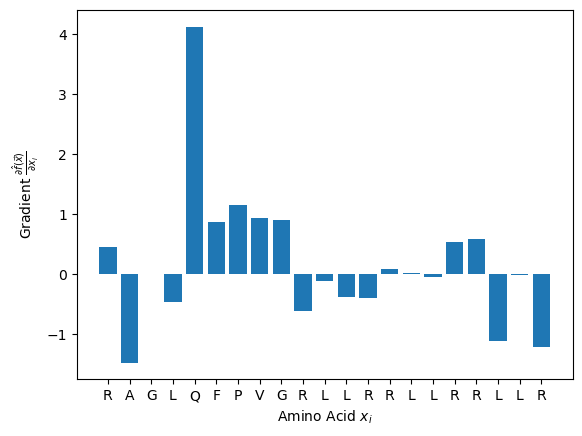

In [13]:
gradient = jax.grad(predict, 0)
g = gradient(sm)
plot_grad(g, s)

## Integrated gradients

In [16]:
def integrated_gradients(sm, N):
    baseline = jnp.zeros((1, L, 21))
    t = jnp.linspace(0, 1, N).reshape(-1, 1, 1)
    path = baseline * (1 - t) + sm * t

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]

    gs = jax.vmap(get_grad)(path)
    # sum pieces (Riemann sum), multiply by (x - x')
    ig = jnp.mean(gs, axis=0, keepdims=True) * (sm - baseline)
    return ig


ig = integrated_gradients(sm, 1024)

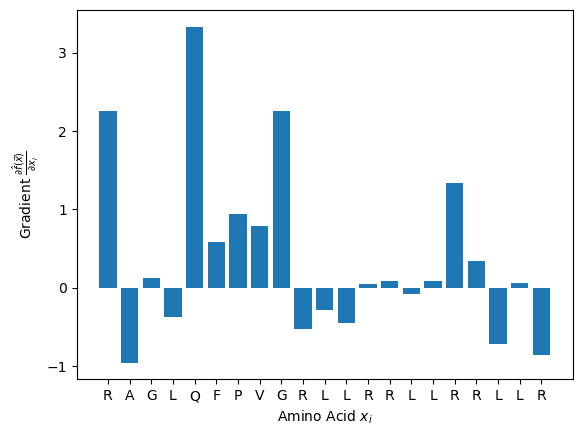

In [17]:
plot_grad(ig, s)

## Smooth grad

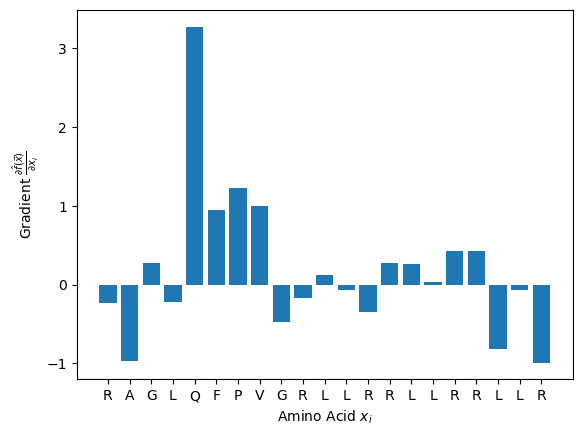

In [18]:
def smooth_gradients(sm, N, rng, sigma=1e-3):
    baseline = jnp.zeros((1, L, 21))
    t = jax.random.normal(rng, shape=(N, sm.shape[1], sm.shape[2])) * sigma
    path = sm + t
    # remove examples that are negative and force summing to 1
    path = jnp.clip(path, 0, 1)
    path /= jnp.sum(path, axis=2, keepdims=True)

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]

    gs = jax.vmap(get_grad)(path)
    # mean
    ig = jnp.mean(gs, axis=0, keepdims=True)
    return ig


sg = smooth_gradients(sm, 1024, jax.random.PRNGKey(0))
plot_grad(sg, s)

## Shapley Value

In [20]:
def shapley(i, sm, sampled_x, rng, model):
    M, F, *_ = sampled_x.shape
    z_choice = jax.random.bernoulli(rng, shape=(M, F))
    # only swap out features within length of sm
    mask = jnp.sum(sm[..., 1:], -1)
    z_choice *= mask
    z_choice = 1 - z_choice
    # construct with and w/o ith feature
    z_choice = z_choice.at[:, i].set(0.0)
    z_choice_i = z_choice.at[:, i].set(1.0)
    # select them via multiplication
    z = sm * z_choice[..., jnp.newaxis] + sampled_x * (1 - z_choice[..., jnp.newaxis])
    z_i = sm * z_choice_i[..., jnp.newaxis] + sampled_x * (
        1 - z_choice_i[..., jnp.newaxis]
    )
    v = model(z_i) - model(z)
    return jnp.squeeze(jnp.mean(v, axis=0))


# assume data is alrady shuffled, so just take M
M = 4096
sl = len(s)
sampled_x = train_data.unbatch().batch(M).as_numpy_iterator().next()[0]
# make batched shapley so we can compute for all features
bshapley = jax.vmap(shapley, in_axes=(0, None, None, 0, None))
sv = bshapley(
    jnp.arange(sl),
    sm,
    sampled_x,
    jax.random.split(jax.random.PRNGKey(0), sl),
    predict,
)

# compute global expectation
eyhat = 0
for xi, yi in full_data.batch(M).as_numpy_iterator():
    eyhat += jnp.mean(predict(xi))
eyhat /= len(full_data)

In [21]:
print(np.sum(sv), predict(sm))

6.7928276 8.086698


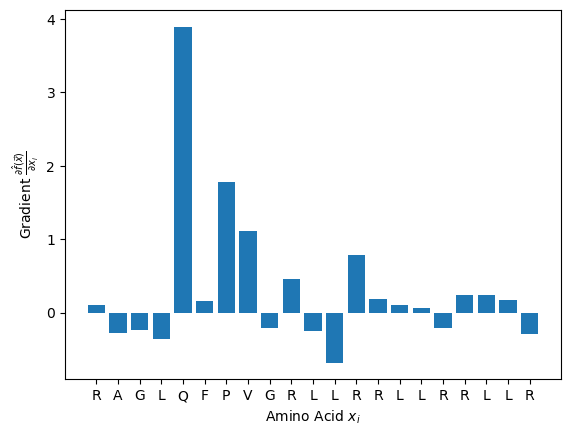

In [22]:
plot_grad(sv, s)